# 논문 정보

레퍼런스 사이트
- https://roytravel.tistory.com/336
- https://ingu627.github.io/code/alexnet_pytorch/
- https://github.com/JJuOn/pytorch-implementation/blob/main/2.AlexNet.ipynb
- https://github.com/Seonghoon-Yu/AI_Paper_Review/blob/master/Classification/AlexNet(2012).ipynb
- https://deep-learning-study.tistory.com/518

아키텍처 2가지 오탈자가 있다.
인풋 데이터 사이즈는 224x224가 아니고 227x 227
두번째 컨벌루션레이어의 커널 사이즈는 3x3이 아니라 5x5 이다.

전체 아키텍처는 top / bottom 두 그룹으로 나뉘는데  GPU 2개를 병렬로 사용한 것이다.

컨벌루션레이어 5개, 풀리커넥티드 레이어 3개 사용.
오버핏 방지를 위해 풀리커넥티드 레이어에 1,2번째에 드랍아웃 0.5레이트 적용 

모델 일반화를 위해 로컬 리스폰즈 노말리제이션 레이어는 컨벌루션 2,4,5층에 적용.

모든 층의 액티베이션 펑션으론 렐루 사용.
기울기소실 문제 해결하고, tanH 보다 에폭당 학습률이 좋은것을 확인.

하이퍼 파라미터

optimizer: SGD
momentum: 0.9
weight decay: 5e-4
batch size: 128
learning rate: 0.01
adjust learning rate: validation error가 현재 lr로 더 이상 개선 안되면 lr을 10으로 나눠줌. 0.01을 lr 초기 값으로 총 3번 줄어듦
epoch: 90
그리고 별도로 레이어에 가중치 초기화를 진행 해줌

편차를 0.01로 하는 zero-mean 가우시안 정규 분포를 모든 레이어의 weight를 초기화
neuron bias: 2, 4, 5번째 convolution 레이어와 fully-connected 레이어에 상수 1로 적용하고 이외 레이어는 0을 적용.

이미지 전처리

고화질 이미지를 256x256 사이즈로 다운 샘플링후 이미지의 center에서 cropped out
각 픽셀에서 training set에 대한 평균 값을 빼줌

1층

conv
input: 227x227x3
output: 55x55x96
96 kernels of size 11x11x3, stride=4, padding=0

maxpooling
input: 55x55x96
output: 27x27x96
3x3 kernel, stride=2

normalization
input: 27x27x96
output: 27x27x96

2층

conv
input: 27x27x96
output: 13x13x256
256 kernels of size 5x5, stride=1, padding=2

maxpooling
input: 27x27x256
output: 13x13x256
3x3 kernel, stride=2

normalization
input: 13x13x256
output: 13x13x256

3층

conv
input: 13x13x256
output: 13x13x384
384 kernels of size 3x3, stride=1, padding=1

4층

conv
input: 13x13x384
output: 13x13x256
384 kernels of size 3xq3, stride=1, padding=1

5층

conv
input: 13x13x384
output: 13x13x256
256 kernels of size 3x3, stride=1, padding=1

maxpooling
input: 55x55x96
output: 27x27x96
3x3 kernel, stride=2

6층

fully connected
input: 6x6x256
output: 4096
parameter: 4096 neurons

7층

fc
input: 4096
output: 4096

8층

fc
input: 4096
output: 1000 softmax classes

이를 바탕으로 전체 코드를 크게 나누어 보자면 5가지 정도가 될 수 있다.
1. 레이어 구성
2. 가중치 초기화 
3. 하이퍼파라미터 설정 
4. 이미지 전처리
5. 학습 로직 작성
참고로 이미지 전처리에 사용하는 transform 메서드에서 사용되는 상수 값은 별도로 논문에 기재되어 있지 않기에 pytorch 공식 documentation에서 기본 값을 가져와서 사용했다.

구현을 위한 데이터셋으론 토치비전에서 제공하는 STL10 데이터셋 사용.
해당 데이터셋은 train, test 셋만 있어서 validation 셋 따로 만들어줄 필요 있음.

# 데이터셋 불러오고 transformation 적용

In [1]:
import os  # 운영 체제와 상호 작용하기 위한 기능을 제공하는 라이브러리
import torchvision.datasets as datasets  # 이미지 데이터셋을 다루기 위한 라이브러리
import torchvision.transforms as transforms  # 이미지 변환을 위한 라이브러리

In [40]:
path2data = '/data'

if not os.path.exists(path2data):
    os.mkdir(path2data)

transformer = transforms.Compose([
    transforms.Resize(227),
    transforms.ToTensor()]) #이미지를 텐서형태로 하기 위함.

In [41]:
training_data = datasets.STL10(
    path2data,
    split='train',
    download=True,
    transform=transformer)
print(train_ds.data.shape)

Files already downloaded and verified
(5000, 3, 96, 96)


In [42]:
test_data = datasets.STL10(
    path2data,
    split='test',
    download=True,
    transform=data_transformer)
print(test_data.data.shape)

Files already downloaded and verified
(8000, 3, 96, 96)


# 데이터 정규화를 위한 평균값, 표준편차값 계산.

In [5]:
import numpy as np

In [6]:
meanRGB = [np.mean(x.numpy(), axis=(1,2)) for x, _ in train_ds]
stdRGB = [np.std(x.numpy(), axis=(1,2)) for x, _ in train_ds]
# axis0->높이
# axis1->행
# axis2->열

In [7]:
meanR = np.mean([m[0] for m in meanRGB])
meanG = np.mean([m[1] for m in meanRGB])
meanB = np.mean([m[2] for m in meanRGB])

In [8]:
print(meanR, meanG, meanB)

0.4467106 0.43980986 0.40664646


In [9]:
stdR = np.mean([s[0] for s in stdRGB])
stdG = np.mean([s[1] for s in stdRGB])
stdB = np.mean([s[2] for s in stdRGB])

In [10]:
print(stdR, stdG, stdB)

0.22414584 0.22148906 0.22389975


# 이미지 트랜스포메이션 정의

In [11]:
train_transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(227),
    transforms.RandomHorizontalFlip(),
    transforms.Normalize([meanR, meanG, meanB],[stdR, stdG, stdB])
])

In [12]:
test_transformer = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize([meanR, meanG, meanB], [stdR, stdG, stdB]),
                transforms.Resize(227)
])

In [13]:
train_ds.transform = train_transformer
test0_ds.transform = test_transformer

In [14]:
img, _ = train_ds[1]
print(img.shape)

torch.Size([3, 227, 227])


# 샘플 이미지 확인

In [15]:
import torch
from torchvision import utils
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [16]:
def show(img, y=None, color=True):
    npimg = img.numpy()
    npimg_tr = np.transpose(npimg, (1, 2, 0))
    plt.imshow(npimg_tr)
    if y is not None:
        plt.title('labels: ' + str(y))

In [17]:
np.random.seed(42)
torch.manual_seed(42)

In [18]:
rnd_inds = int(np.random.randint(0, len(train_ds), 1))
print(rnd_inds)
img, label = train_ds[rnd_inds]
print('images indices: ', rnd_inds)

860
images indices:  860


C:\Users\Administrator\AppData\Local\Temp\ipykernel_10524\1391974320.py:1: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rnd_inds = int(np.random.randint(0, len(train_ds), 1))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7636112..2.625697].


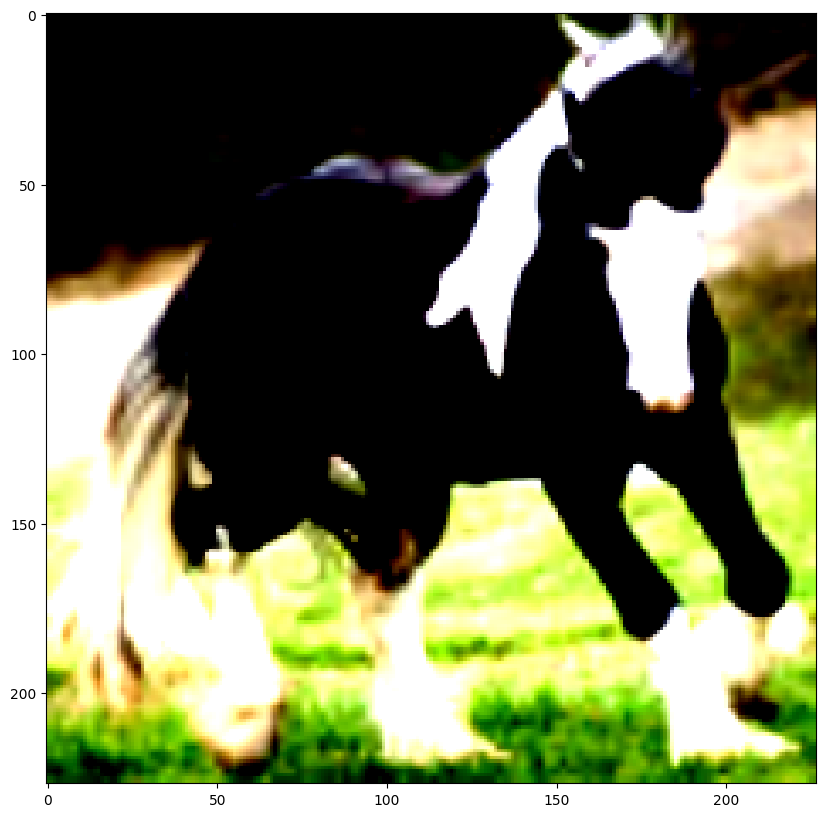

In [19]:
plt.figure(figsize=(10, 10))
show(img)

In [20]:
# 이미지 카테고리 계산
import collections
y_train = [y for _, y in train_ds]
counter_train = collections.Counter(y_train)
print(counter_train)
# 0~9까지 각 500개

Counter({1: 500, 5: 500, 6: 500, 3: 500, 9: 500, 7: 500, 4: 500, 8: 500, 0: 500, 2: 500})


In [21]:
# STL10 데이터에는 벨리데이션이 없어서 따로 만들어주기
# StratifiedShuffleSplit 함수는 각 레이블에서 동일한 비율로 이미지 인덱스를 추출.
# Subset 함수를 활용하여 추출한 인덱스로 데이터셋을 분할해주기
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
indices = list(range(len(test0_ds)))
y_test0 = [y for _,y in test0_ds]
for test_index, val_index in sss.split(indices, y_test0):
    print('test :', len(test_index) , 'val :', len(val_index))

test : 6400 val : 1600


In [22]:
# Subset 함수로 test dataset과 val dataset을 나눕니다.
# test0 dataset이 업데이트되면 test dataset과 val dataset 모두 업데이트 됩니다.
from torch.utils.data import Subset
val_ds = Subset(test0_ds, val_index)
test_ds = Subset(test0_ds, test_index)

In [23]:
import collections
import numpy as np

y_test = [y for _, y in test_ds]
y_val = [y for _, y in val_ds]

counter_test = collections.Counter(y_test)
counter_val = collections.Counter(y_val)
print(counter_test)
print(counter_val)

Counter({6: 640, 0: 640, 4: 640, 5: 640, 9: 640, 2: 640, 3: 640, 1: 640, 7: 640, 8: 640})
Counter({2: 160, 8: 160, 3: 160, 6: 160, 4: 160, 1: 160, 5: 160, 9: 160, 0: 160, 7: 160})


# DataLoader 생성

In [24]:
from torch.utils.data import DataLoader

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=32, shuffle=False)


for x,y in train_dl:
    print(x.shape)
    print(y.shape)
    break

for x,y in val_dl:
    print(x.shape)
    print(y.shape)
    break

torch.Size([32, 3, 227, 227])
torch.Size([32])
torch.Size([32, 3, 227, 227])
torch.Size([32])


# 모델 구축

In [25]:
# 에폭 배치사이즈 디바이스 정의
epochs = 10 # 훈련 반복수
batch_size = 512 # 배치 크기

device = ("cuda" if torch.cuda.is_available() else "cpu") # device 정의
class_names = ['airplane', 'bird', 'car', 'cat', 'deer',
               'dog', 'horse', 'monkey', 'ship', 'truck'] # 총 10개의 클래스

print(torch.__version__)
print(device)


2.3.0+cpu
cpu


In [26]:
import torch.nn as nn  # 신경망 모델을 정의하는 데 사용되는 모듈과 클래스를 제공하는 라이브러리
import torch.nn.functional as F  # 신경망의 함수형 인터페이스를 제공하는 라이브러리

class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.net = nn.Sequential( # conv layer
            nn.Conv2d(kernel_size=11, in_channels=3, out_channels=96, stride=4, padding=0),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(kernel_size=5, in_channels=96, out_channels=256, stride=1, padding=2),
            nn.ReLU(),
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),
            nn.MaxPool2d(kernel_size=3, stride=1),

            nn.Conv2d(kernel_size=3, in_channels=256, out_channels=384, stride=1, padding=1),
            nn.ReLU(),
            
            nn.Conv2d(kernel_size=3, in_channels=384, out_channels=384, stride=1, padding=1),
            nn.ReLU(),

            nn.Conv2d(kernel_size=3, in_channels=384, out_channels=256, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=1)
        )
        
        self.classifier = nn.Sequential( # fc layer
            nn.Dropout(p=0.5, inplace=True),
            nn.Linear(in_features=(256 * 6 * 6), out_features=4096),
            nn.ReLU(),
            nn.Dropout(p=0.5, inplace=True),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(),
            nn.Linear(in_features=4096, out_features=num_classes),
        )

        self.init_bias()
        
# AlexNet 논문에 따르면, 2번째, 4번째, 5번째 합성곱 층과 
# 모든 완전 연결 층의 바이어스를 1로 초기화했다고 합니다.
    def init_bias(self):
        for layer in self.net:
            if isinstance(layer, nn.Conv2d):
                nn.init.normal_(layer.weight, mean=0, std=0.01)
                nn.init.constant_(layer.bias, 0)
        # original paper = 1 for Conv2d layers 2nd, 4th, and 5th conv layers
        nn.init.constant_(self.net[4].bias, 1)
        nn.init.constant_(self.net[10].bias, 1)
        nn.init.constant_(self.net[12].bias, 1)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.net(x)
        x = x.view(-1, 256 * 6* 6)
        x = self.classifier(x)
        return x

In [27]:
# check the model
model = AlexNet().to(device)
print(model)

AlexNet(
  (net): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU(inplace=True)
    (2): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): ReLU()
    (6): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=True)
    (1): Linear(in_features=9216, out_features=4096, bias=True)


In [29]:
# get the model summary
from torchsummary import summary
summary(model, input_size=(3, 227, 227), device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 55, 55]          34,944
              ReLU-2           [-1, 96, 55, 55]               0
 LocalResponseNorm-3           [-1, 96, 55, 55]               0
         MaxPool2d-4           [-1, 96, 27, 27]               0
            Conv2d-5          [-1, 256, 27, 27]         614,656
              ReLU-6          [-1, 256, 27, 27]               0
 LocalResponseNorm-7          [-1, 256, 27, 27]               0
         MaxPool2d-8          [-1, 256, 13, 13]               0
            Conv2d-9          [-1, 384, 13, 13]         885,120
             ReLU-10          [-1, 384, 13, 13]               0
           Conv2d-11          [-1, 384, 13, 13]       1,327,488
             ReLU-12          [-1, 384, 13, 13]               0
           Conv2d-13          [-1, 256, 13, 13]         884,992
             ReLU-14          [-1, 256,

In [31]:
# check weight initialization
for p in model.parameters():
    print(p)
    break

Parameter containing:
tensor([[[[-2.4352e-03,  6.2035e-03, -6.4266e-04,  ..., -1.2443e-02,
            9.9962e-03,  9.3936e-03],
          [ 9.4660e-03, -1.8899e-04,  1.3443e-02,  ..., -2.8415e-03,
           -1.3260e-02, -2.7076e-03],
          [-2.6842e-03,  1.9472e-02,  5.8697e-03,  ...,  7.6307e-03,
           -1.1026e-02,  1.1588e-02],
          ...,
          [-6.9773e-03,  1.2548e-02,  1.6715e-02,  ...,  5.9699e-03,
            7.9209e-04, -3.4047e-03],
          [ 6.5603e-03,  6.6963e-03, -1.7391e-04,  ...,  9.3804e-03,
            3.9515e-03, -1.0190e-02],
          [ 1.2952e-02, -4.2072e-03,  7.8752e-03,  ...,  8.1956e-03,
            9.0110e-03, -2.0635e-03]],

         [[-1.4580e-03,  3.2719e-03,  7.1539e-03,  ...,  5.2211e-03,
            1.4014e-02,  7.2430e-03],
          [-7.8571e-04, -6.3175e-03,  1.2097e-02,  ...,  1.7489e-02,
            3.7629e-03,  1.1312e-03],
          [-4.3247e-03, -1.3691e-02, -2.1833e-02,  ...,  1.7250e-02,
           -8.0092e-03,  9.5663e-03]

# 모델 학습

In [ ]:
# 트레인 정의
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_dl):
        # enumberate() : 인덱스와 원소로 이루어진 튜플(tuple)을 만들어줌
        target = target.type(torch.LongTensor)
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad() # 항상 backpropagation 하기전에 미분(gradient)을 zero로 만들어주고 시작해야 한다.
        output = model(data)
        loss = criterion(output, target) # criterion = loss_fn
        loss.backward() # Computes the gradient of current tensor w.r.t. graph leaves
        optimizer.step() # step() : 파라미터를 업데이트함
        if (batch_idx + 1) % 30 == 0:
            print("Train Epoch:{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [32]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target, reduction='sum').item()
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(test_loader.dataset)  # -> mean
        print("\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
            test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset)))
        print('='*50)

In [33]:
for epoch in range(1, epochs+1):
    train(model, device, train_dl, optimizer, epoch)
    test(model, device, val_dl)

NameError: name 'train' is not defined